# EDA for MRI based brain tumor's IDH status classification with MONAI (3D multiparametric MRI)

Exploratory data analysis before constructing a training workflow for binary classification task.  

The Brain tumor dataset can be downloaded from 
https://ipp.cbica.upenn.edu/ and  http://medicaldecathlon.com/.  

Target: IDH classification based on whole brain, tumour core, whole tumor, and enhancing tumor from MRI 
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  


Source: BRATS 2020/2021 datasets.  
Challenge: RSNA-MICCAI Brain Tumor Radiogenomic Classification

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right). (Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))  
![image](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/42/7283692/6975210/6975210-fig-3-source-large.gif)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
2. the tumor core (red) visible in T2 (Fig.B).
3. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
4. The segmentations are used to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import sys
import gc
import logging
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import DynUNet, EfficientNetBN, DenseNet121, SegResNet, SegResNetVAE
from monai.data import CacheDataset, Dataset, DataLoader, ThreadDataLoader
from torch.utils.data import WeightedRandomSampler

import monai
from monai.transforms import (
    Activations,
    AsDiscrete,
    CastToTyped,
    Compose, 
    CropForegroundd,
    ResizeWithPadOrCrop,
    ResizeWithPadOrCropd,
    Spacingd,
    RandRotate90d,
    Resized,
    EnsureChannelFirstd, 
    Orientationd,
    LoadImaged,
    NormalizeIntensity,
    HistogramNormalize,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandAffined,
    RandFlipd,
    Flipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandGibbsNoised,
    RandStdShiftIntensityd,
    RandScaleIntensityd,
    RandZoomd, 
    SpatialCrop, 
    SpatialPadd, 
    MapTransform,
    CastToType,
    ToTensord,
    AddChanneld,
    MapTransform,
    Orientationd,
    ScaleIntensityd,
    ScaleIntensity,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRange,
    RandShiftIntensityd,
    RandAdjustContrastd,
    AdjustContrastd,
    Rotated,
    ToNumpyd,
    ToDeviced,
    EnsureType,
    EnsureTyped,
    DataStatsd,
)

from monai.config import KeysCollection
from monai.transforms.compose import MapTransform, Randomizable
from collections.abc import Iterable
from typing import Any, Dict, Hashable, Mapping, Optional, Sequence, Tuple, Union
from monai.utils import set_determinism
from monai.utils import (
    ensure_tuple,
    ensure_tuple_rep,
    ensure_tuple_size,
)

from monai.optimizers import LearningRateFinder

from monai.transforms.compose import MapTransform
from monai.transforms.utils import generate_spatial_bounding_box
from skimage.transform import resize
from monai.losses import DiceCELoss, DiceLoss
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


from monai.metrics import DiceMetric, ROCAUCMetric
from monai.data import decollate_batch
import glob
import monai
from monai.metrics import compute_meandice
import random
import pickle
from collections import OrderedDict
from typing import Sequence, Optional
import ipywidgets as widgets
from itertools import compress
import SimpleITK as sitk
import torchio as tio

import sklearn
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, recall_score, \
accuracy_score, precision_score, f1_score, make_scorer 

from monai.utils import ensure_tuple_rep
from monai.networks.layers.factories import Conv, Dropout, Norm, Pool
import matplotlib.pyplot as plt
from ranger21 import Ranger21

### monai and ignite based imports
import logging
from ignite.engine import Engine, Events
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar
from ignite.engine import (
    Events,
    _prepare_batch,
    create_supervised_evaluator,
    create_supervised_trainer,
)
from ignite.handlers import EarlyStopping, ModelCheckpoint

from itkwidgets import view
import random
monai.config.print_config()
#from sliding_window_inference_classes import sliding_window_inference_classes

MONAI version: 0.9.0
Numpy version: 1.22.3
Pytorch version: 1.10.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/mmiv-ml/anaconda3/envs/sa_tumorseg22/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

In [3]:
MAX_THREADS =2
sitk.ProcessObject.SetGlobalDefaultNumberOfThreads(MAX_THREADS)

In [4]:
seeds = 40961024
set_determinism(seed=seeds)
##np.random.seed(seeds) np random seed does not work here
!nvidia-smi

Wed Jun 29 06:33:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   38C    P0    42W / 300W |    108MiB / 32505MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [5]:
pd.set_option('display.max_colwidth', None)
data_rpath = '/home/mmiv-ml/data'
traindata_folder = os.path.join(data_rpath,'MICCAI_BraTS2020_TrainingData')
traindata_folder

'/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData'

In [6]:
train_images20t1 = list()
train_images20t1ce = list()
train_images20t2 = list()
train_images20flair = list()
train_images20label = list()
train_BrainROI20Masks = list()
SubIDList = list()
t1wList = glob.glob(os.path.join(traindata_folder, 'BraTS20_*/BraTS20_*_t1.nii.gz'))
BrainROI20_folder = os.path.join(data_rpath, 'ROIBrain_MICCAI_BraTS2020')

for at1wPath in t1wList:
    aSubID = os.path.basename(os.path.dirname(at1wPath))
    SubIDList.append(aSubID)
    train_images20t1.append(at1wPath)
    train_images20t1ce.append(glob.glob(f"{traindata_folder}/{aSubID}/{aSubID}_t1ce.nii.gz*")[0])
    train_images20t2.append(glob.glob(f"{traindata_folder}/{aSubID}/{aSubID}_t2.nii.gz*")[0])
    train_images20flair.append(glob.glob(f"{traindata_folder}/{aSubID}/{aSubID}_flair.nii.gz*")[0])
    train_images20label.append(glob.glob(f"{traindata_folder}/{aSubID}/{aSubID}_seg.nii.gz*")[0])
    train_BrainROI20Masks.append(glob.glob(f"{BrainROI20_folder}/{aSubID}/{aSubID}_BrainROI.nii.gz*")[0])
    
    

In [7]:
BraTS20AllSubjectsDF = pd.DataFrame.from_dict({'BraTS2020':SubIDList, 't1wPath':train_images20t1, 't1cwPath':train_images20t1ce, 't2wPath':train_images20t2, 'flairPath':train_images20flair,\
                        'segPath':train_images20label, 't1w_BrainmaskPath':train_BrainROI20Masks})
BraTS20AllSubjectsDF

,BraTS2020,t1wPath,t1cwPath,t2wPath,flairPath,segPath,t1w_BrainmaskPath
0,BraTS20_Training_009,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009/BraTS20_Training_009_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009/BraTS20_Training_009_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009/BraTS20_Training_009_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009/BraTS20_Training_009_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009/BraTS20_Training_009_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_009/BraTS20_Training_009_BrainROI.nii.gz
1,BraTS20_Training_366,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366/BraTS20_Training_366_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366/BraTS20_Training_366_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366/BraTS20_Training_366_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366/BraTS20_Training_366_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366/BraTS20_Training_366_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_366/BraTS20_Training_366_BrainROI.nii.gz
2,BraTS20_Training_089,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089/BraTS20_Training_089_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089/BraTS20_Training_089_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089/BraTS20_Training_089_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089/BraTS20_Training_089_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089/BraTS20_Training_089_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_089/BraTS20_Training_089_BrainROI.nii.gz
3,BraTS20_Training_119,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119/BraTS20_Training_119_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119/BraTS20_Training_119_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119/BraTS20_Training_119_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119/BraTS20_Training_119_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119/BraTS20_Training_119_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_119/BraTS20_Training_119_BrainROI.nii.gz
4,BraTS20_Training_274,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_274/BraTS20_Training_274_BrainROI.nii.gz
...,...,...,...,...,...,...,...
364,BraTS20_Training_286,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_286/BraTS20_Training_286_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_286/BraTS20_Training_286_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_286/BraTS20_Training_286_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_286/BraTS20_Training_286_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_286/BraTS20_Training_286_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_286/BraTS20_Training_286_BrainROI.nii.gz
365,BraTS20_Training_030,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingDat

### Read filenamming DataFrame

In [10]:
BraTS21_17MaapingDF =pd.read_csv('assets/BraTS21-17_Mapping.csv')
BraTS21_17MaapingDF = BraTS21_17MaapingDF.rename(columns = {'Cohort Name (if publicly available)':'CohortName', 'Local ID\xa0':'TCGA_ID', \
                                                           'Site No (represents the originating institution)':'SiteNo_Originating_Institution'})
BraTS21_17MaapingDF

,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,CohortName,SiteNo_Originating_Institution,TCGA_ID
0,BraTS2021_01163,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-004
1,BraTS2021_01164,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-034
2,BraTS2021_01165,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-036
3,BraTS2021_01166,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-042
4,BraTS2021_00101,NaN,NaN,NaN,NaN,CPTAC-GBM,20,C3L-00016
...,...,...,...,...,...,...,...,...
1250,BraTS2021_01162,NaN,NaN,NaN,NaN,Private Collection,23,NaN
1251,NaN,BraTS20_Training_353,NaN,NaN,NaN,IvyGAP,16,W36
1252,NaN,BraTS20_Training_354,NaN,NaN,NaN,IvyGAP,16,W43
1253,NaN,BraTS20_Training_355,NaN,NaN,NaN,IvyGAP,16,W39


In [18]:
# BraTS21_17MaapingDF = BraTS21_17MaapingDF.dropna(axis = 0, subset = ['TCGA_ID'])
# BraTS21_17MaapingDFCheck = BraTS21_17MaapingDF.loc[BraTS21_17MaapingDF['TCGA_ID'].str.contains('LGG')]
# len(BraTS21_17MaapingDFCheck['TCGA_ID'])
# BraTS21_17MaapingDFCheck

In [19]:
BraTS21_17MaapingDF = BraTS21_17MaapingDF.dropna(axis = 0, subset = ['TCGA_ID'])
BraTS21_17MaapingDF = BraTS21_17MaapingDF.loc[BraTS21_17MaapingDF['TCGA_ID'].str.contains('TCGA')]
len(BraTS21_17MaapingDF['TCGA_ID'])

167

In [20]:
BraTS21_17MaapingDF

,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,CohortName,SiteNo_Originating_Institution,TCGA_ID
697,BraTS2021_00100,BraTS20_Training_174,BraTS19_TCIA01_231_1,Brats18_TCIA01_231_1,Brats17_TCIA_231_1,TCGA-GBM,5,TCGA-02-0085
698,BraTS2021_00102,BraTS20_Training_177,BraTS19_TCIA01_411_1,Brats18_TCIA01_411_1,Brats17_TCIA_411_1,TCGA-GBM,5,TCGA-02-0102
699,BraTS2021_00104,BraTS20_Training_229,BraTS19_TCIA04_479_1,Brats18_TCIA04_479_1,Brats17_TCIA_479_1,TCGA-GBM,8,TCGA-12-1094
700,BraTS2021_00105,BraTS20_Training_208,BraTS19_TCIA02_222_1,Brats18_TCIA02_222_1,Brats17_TCIA_222_1,TCGA-GBM,6,TCGA-06-1802
701,BraTS2021_00106,BraTS20_Training_241,BraTS19_TCIA06_372_1,Brats18_TCIA06_372_1,Brats17_TCIA_372_1,TCGA-GBM,10,TCGA-19-2631
...,...,...,...,...,...,...,...,...
859,BraTS2021_01536,BraTS20_Training_331,BraTS19_TCIA13_621_1,Brats18_TCIA13_621_1,Brats17_TCIA_621_1,TCGA-LGG,15,TCGA-HT-8018
860,BraTS2021_01663,BraTS20_Training_332,BraTS19_TCIA13_653_1,Brats18_TCIA13_653_1,Brats17_TCIA_653_1,TCGA-LGG,15,TCGA-HT-8111
861,BraTS2021_01664,BraTS20_Training_333,BraTS19_TCIA13_642_1,Brats18_TCIA13_642_1,Brats17_TCIA_642_1,TCGA-LGG,15,TCGA-HT-8114
862,BraTS2021_01665,BraTS20_Training_334,BraTS19_TCIA13_624_1,Brats18_TCIA13_624_1,Brats17_TCIA_624_1,TCGA-LGG,15,TCGA-HT-8563


In [10]:
BraTS20AllSubjectsDF = BraTS20AllSubjectsDF.merge(BraTS21_17MaapingDF, how='inner', on='BraTS2020', indicator = 'is_merged_1', validate = 'one_to_one')  ####copy = True by default
BraTS20AllSubjectsDF

,BraTS2020,t1wPath,t1cwPath,t2wPath,flairPath,segPath,t1w_BrainmaskPath,BraTS2021,BraTS2019,BraTS2018,BraTS2017,CohortName,SiteNo_Originating_Institution,TCGA_ID,is_merged_1
0,BraTS20_Training_274,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_274/BraTS20_Training_274_BrainROI.nii.gz,BraTS2021_01479,BraTS19_TCIA09_141_1,Brats18_TCIA09_141_1,Brats17_TCIA_141_1,TCGA-LGG,12,TCGA-CS-5396,both
1,BraTS20_Training_293,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_293/BraTS20_Training_293_BrainROI.nii.gz,BraTS2021_01498,BraTS19_TCIA10_410_1,Brats18_TCIA10_410_1,Brats17_TCIA_410_1,TCGA-LGG,13,TCGA-DU-7018,both
2,BraTS20_Training_190,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_190/BraTS20_Training_190_BrainROI.nii.gz,BraTS2021_01300,BraTS19_TCIA02_226_1,Brats18_TCIA02_226_1,Brats17_TCIA_226_1,TCGA-GBM,6,TCGA-06-0158,both
3,BraTS20_Training_298,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_298/BraTS20_Training_298_BrainROI.nii.gz,BraTS2021_01503,BraTS19_TCIA10_276_1,Brats18_TCIA10_276_1,Brats17_TCIA_276_1,TCGA-LGG,13,TCGA-DU-7300,both
4,BraTS20_Training_334,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_334/BraTS20_Training_334_BrainROI.nii.gz,BraTS2021_01665,BraTS19_TCIA13_624_1,Brats18_TCIA13_624_1,Brats17_TCIA_624_1,TCGA-LGG,15,TCGA-HT-8563,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,BraTS20_Training_249,/home/mmiv-ml/data

In [11]:
BraTS20AllSubjectsDF.columns

Index(['BraTS2020', 't1wPath', 't1cwPath', 't2wPath', 'flairPath', 'segPath',
       't1w_BrainmaskPath', 'BraTS2021', 'BraTS2019', 'BraTS2018', 'BraTS2017',
       'CohortName', 'SiteNo_Originating_Institution', 'TCGA_ID',
       'is_merged_1'],
      dtype='object')

## Reading dataframe of IDH wildtype/mutated 

In [12]:
GBM_IDH_DF = pd.read_excel('assets/Yogananda_etal_GBM_IDH_mutation_status_Neuro_Oncology_2020.xlsx', header = 0)
GBM_IDH_DF = GBM_IDH_DF.iloc[1:,:]
GBM_IDH_DF

,SUBJECT ID,Age,Gender,Histology,Grade,IDH,IDH .1,1p/19q co-deletion,Survival (months),Karnofsky,Cross-validation group
1,TCGA-02-0003,50.0,male,glioblastoma,G4,WT,NaN,non-codel,4.7311,100,1.0
2,TCGA-02-0006,56.0,female,glioblastoma,G4,WT,NaN,non-codel,18.3330,80,3.0
3,TCGA-02-0009,61.0,female,glioblastoma,G4,WT,NaN,non-codel,10.5793,80,1.0
4,TCGA-02-0011,18.0,female,glioblastoma,G4,WT,NaN,non-codel,20.6986,80,1.0
5,TCGA-02-0027,33.0,female,glioblastoma,G4,WT,NaN,non-codel,12.1563,100,2.0
...,...,...,...,...,...,...,...,...,...,...,...
210,TCGA-HT-8113,49.0,female,oligodendroglioma,G2,Mutant,IDH2,non-codel,29.5694,NaN,1.0
211,TCGA-HT-8114,36.0,male,oligoastrocytoma,G3,Mutant,IDH1,non-codel,3.8769,NaN,1.0
212,TCGA-HT-8563,30.0,female,astrocytoma,G3,Mutant,IDH1,non-codel,16.0332,NaN,2.0
213,TCGA-HT-A5RC,70.0,female,astrocytoma,G3,WT,NaN,non-codel,5.3225,40,3.0


In [13]:
GBM_IDH_DF = GBM_IDH_DF.rename(columns = {'SUBJECT ID':'TCGA_ID','IDH ':'IDH', 'IDH .1':'IDH_1', '1p/19q co-deletion\xa0': '1p19q_co_deletion', 'Survival (months)\xa0':'Survival_months', 'Cross-validation group':'CV_group'})
GBM_IDH_DF

,TCGA_ID,Age,Gender,Histology,Grade,IDH,IDH_1,1p19q_co_deletion,Survival_months,Karnofsky,CV_group
1,TCGA-02-0003,50.0,male,glioblastoma,G4,WT,NaN,non-codel,4.7311,100,1.0
2,TCGA-02-0006,56.0,female,glioblastoma,G4,WT,NaN,non-codel,18.3330,80,3.0
3,TCGA-02-0009,61.0,female,glioblastoma,G4,WT,NaN,non-codel,10.5793,80,1.0
4,TCGA-02-0011,18.0,female,glioblastoma,G4,WT,NaN,non-codel,20.6986,80,1.0
5,TCGA-02-0027,33.0,female,glioblastoma,G4,WT,NaN,non-codel,12.1563,100,2.0
...,...,...,...,...,...,...,...,...,...,...,...
210,TCGA-HT-8113,49.0,female,oligodendroglioma,G2,Mutant,IDH2,non-codel,29.5694,NaN,1.0
211,TCGA-HT-8114,36.0,male,oligoastrocytoma,G3,Mutant,IDH1,non-codel,3.8769,NaN,1.0
212,TCGA-HT-8563,30.0,female,astrocytoma,G3,Mutant,IDH1,non-codel,16.0332,NaN,2.0
213,TCGA-HT-A5RC,70.0,female,astrocytoma,G3,WT,NaN,non-codel,5.3225,40,3.0


In [14]:
setNotAvailable = set(GBM_IDH_DF['TCGA_ID'])- set(BraTS21_17MaapingDF['TCGA_ID'])
print(len(setNotAvailable))
setNotAvailable

79


{'TCGA-02-0003',
 'TCGA-02-0048',
 'TCGA-02-0060',
 'TCGA-06-0127',
 'TCGA-06-0128',
 'TCGA-06-0129',
 'TCGA-06-0132',
 'TCGA-06-0133',
 'TCGA-06-0143',
 'TCGA-06-0147',
 'TCGA-06-0157',
 'TCGA-06-0166',
 'TCGA-06-0168',
 'TCGA-06-0174',
 'TCGA-06-0189',
 'TCGA-06-0213',
 'TCGA-06-0237',
 'TCGA-06-0241',
 'TCGA-06-0645',
 'TCGA-06-0648',
 'TCGA-06-0649',
 'TCGA-06-1806',
 'TCGA-06-5412',
 'TCGA-12-1093',
 'TCGA-12-1602',
 'TCGA-14-0789',
 'TCGA-14-1829',
 'TCGA-19-1388',
 'TCGA-19-1390',
 'TCGA-27-1835',
 'TCGA-27-1838',
 'TCGA-76-4926',
 'TCGA-76-6192',
 'TCGA-CS-4941',
 'TCGA-CS-4943',
 'TCGA-CS-5395',
 'TCGA-CS-6290',
 'TCGA-CS-6667',
 'TCGA-DU-5849',
 'TCGA-DU-5852',
 'TCGA-DU-5853',
 'TCGA-DU-5871',
 'TCGA-DU-6395',
 'TCGA-DU-6397',
 'TCGA-DU-6399',
 'TCGA-DU-6400',
 'TCGA-DU-6401',
 'TCGA-DU-6405',
 'TCGA-DU-6407',
 'TCGA-DU-6408',
 'TCGA-DU-8163',
 'TCGA-DU-8165',
 'TCGA-DU-A5TP',
 'TCGA-DU-A6S2',
 'TCGA-DU-A6S3',
 'TCGA-DU-A6S6',
 'TCGA-FG-6688',
 'TCGA-FG-6690',
 'TCGA-FG-7643

In [15]:
BraTS20SubjectsIDHDF = BraTS20AllSubjectsDF.merge(GBM_IDH_DF, how='inner', on  = 'TCGA_ID', indicator = 'is_merged_2', validate = 'one_to_one') ##copy = True by default
BraTS20SubjectsIDHDF

,BraTS2020,t1wPath,t1cwPath,t2wPath,flairPath,segPath,t1w_BrainmaskPath,BraTS2021,BraTS2019,BraTS2018,...,Gender,Histology,Grade,IDH,IDH_1,1p19q_co_deletion,Survival_months,Karnofsky,CV_group,is_merged_2
0,BraTS20_Training_274,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_274/BraTS20_Training_274_BrainROI.nii.gz,BraTS2021_01479,BraTS19_TCIA09_141_1,Brats18_TCIA09_141_1,...,female,oligodendroglioma,G3,Mutant,IDH1,codel,9.9550,90,2.0,both
1,BraTS20_Training_293,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_293/BraTS20_Training_293_BrainROI.nii.gz,BraTS2021_01498,BraTS19_TCIA10_410_1,Brats18_TCIA10_410_1,...,female,oligodendroglioma,G3,Mutant,IDH1,codel,30.6536,90,2.0,both
2,BraTS20_Training_190,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_190/BraTS20_Training_190_BrainROI.nii.gz,BraTS2021_01300,BraTS19_TCIA02_226_1,Brats18_TCIA02_226_1,...,male,glioblastoma,G4,WT,NaN,non-codel,10.8093,80,1.0,both
3,BraTS20_Training_298,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_298/BraTS20_Training_298_BrainROI.nii.gz,BraTS2021_01503,BraTS19_TCIA10_276_1,Brats18_TCIA10_276_1,...,female,oligodendroglioma,G3,Mutant,IDH1,codel,61.9643,90,3.0,both
4,BraTS20_Training_334,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_334/BraTS20_Training_334_BrainROI.nii.gz,BraTS2021_01665,BraTS19_TCIA13_624_1,Brats18_TCIA13_624_1,...,female,astrocytoma,G3,Mutant,IDH1,non-codel,16

In [16]:
BraTS20SubjectsIDHDF['TCGA_ID']

0      TCGA-CS-5396
1      TCGA-DU-7018
2      TCGA-06-0158
3      TCGA-DU-7300
4      TCGA-HT-8563
           ...     
130    TCGA-14-1456
131    TCGA-76-6191
132    TCGA-02-0069
133    TCGA-06-0139
134    TCGA-DU-5874
Name: TCGA_ID, Length: 135, dtype: object

### Adding meta information

In [17]:
BraTS21Meta4mcsvAll = pd.read_csv('/home/mmiv-ml/saruarlive/tumorSeg21/assets/BraTS21MetaDf_14Jul21.csv')
BraTS21Meta4mcsvAll = BraTS21Meta4mcsvAll.rename(columns = {'BraTS21ID':'BraTS2021'})
display(BraTS21Meta4mcsvAll)

,BraTS2021,WTVol,TCVol,ETVol,EDVol,NECVol,WT_CoordX,WT_CoordY,WT_CoordZ,TC_CoordX,...,TC_CoordZ,ET_CoordX,ET_CoordY,ET_CoordZ,ED_CoordX,ED_CoordY,ED_CoordZ,NEC_CoordX,NEC_CoordY,NEC_CoordZ
0,BraTS2021_00000,57305,44469,32731,12836,11738,139.281895,83.091039,70.933741,139.826418,...,69.387978,139.678317,87.178241,69.121842,137.395450,71.646074,76.288875,140.239393,84.209576,70.130090
1,BraTS2021_00002,190594,34899,23651,155695,11248,140.748654,95.734136,79.212184,140.730193,...,81.028482,141.101729,93.647119,80.929855,140.752792,96.423084,78.805061,139.948969,90.586060,81.235864
2,BraTS2021_00003,99239,41466,24252,57773,17214,133.127944,116.574562,108.264694,127.113515,...,100.773501,125.979754,112.939758,102.008989,137.444741,119.623302,113.641424,128.710817,111.463402,99.032880
3,BraTS2021_00005,124783,48041,23854,76742,24187,145.976752,148.827893,104.724682,148.804854,...,107.885993,150.125430,152.294751,111.279198,144.206341,147.093638,102.745680,147.502460,150.911316,104.539505
4,BraTS2021_00006,137911,51954,26448,85957,25506,128.723169,74.510148,73.983294,126.545752,...,69.628229,126.701263,67.094525,69.306866,130.039241,78.924520,76.615575,126.384498,67.322904,69.961460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,BraTS2021_01662,94116,62513,34133,31603,28380,98.079360,107.796676,105.241064,100.674868,...,107.490202,102.328011,105.616090,109.603902,92.945258,109.131158,100.792108,98.686610,108.933263,104.948027
1247,BraTS2021_01663,56445,2366,1929,54079,437,143.458163,101.100275,110.376384,150.620456,...,111.028318,150.641265,86.419388,111.122862,143.144807,101.732817,110.347861,150.528604,87.627002,110.610984
1248,BraTS2021_01664,188686,177361,8755,11325,168606,149.914382,160.128897,90.551387,150.245809,...,91.510670,157.823986,168.977841,93.326099,144.723885,145.483532,75.528035,149.852307,160.653114,91.416403
1249,BraTS2021_01665,151508,12769,11757,138739,1012,80.833639,139.299245,66.814624,81.806484,...,69.816587,81.914264,146.606787,69.382751,80.744102,138.641146,66.538335,80.554348,144.624506,74.856719


In [18]:
BraTS20SubjectsIDHWithMetaDF = BraTS20SubjectsIDHDF.merge(BraTS21Meta4mcsvAll, how='inner', on = 'BraTS2021', indicator = 'is_merged_3', validate = 'one_to_one') ##copy = True by defauls
#BraTS20SubjectsIDHWithMetaDF.to_csv('assets/BraTS20SubjectsIDHWithMetaDF.csv', index = False, header = True)
BraTS20SubjectsIDHWithMetaDF

,BraTS2020,t1wPath,t1cwPath,t2wPath,flairPath,segPath,t1w_BrainmaskPath,BraTS2021,BraTS2019,BraTS2018,...,ET_CoordX,ET_CoordY,ET_CoordZ,ED_CoordX,ED_CoordY,ED_CoordZ,NEC_CoordX,NEC_CoordY,NEC_CoordZ,is_merged_3
0,BraTS20_Training_274,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_274/BraTS20_Training_274_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_274/BraTS20_Training_274_BrainROI.nii.gz,BraTS2021_01479,BraTS19_TCIA09_141_1,Brats18_TCIA09_141_1,...,102.788589,97.639325,94.684363,118.038612,106.882949,88.290266,106.202255,91.666134,96.335216,both
1,BraTS20_Training_293,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_293/BraTS20_Training_293_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_293/BraTS20_Training_293_BrainROI.nii.gz,BraTS2021_01498,BraTS19_TCIA10_410_1,Brats18_TCIA10_410_1,...,101.672477,85.079209,81.828045,96.746334,107.863478,83.794617,99.950014,88.945683,89.526921,both
2,BraTS20_Training_190,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190/BraTS20_Training_190_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_190/BraTS20_Training_190_BrainROI.nii.gz,BraTS2021_01300,BraTS19_TCIA02_226_1,Brats18_TCIA02_226_1,...,161.133893,117.501382,72.152114,158.558518,124.733076,69.336469,161.917178,114.233129,78.978528,both
3,BraTS20_Training_298,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_298/BraTS20_Training_298_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_298/BraTS20_Training_298_BrainROI.nii.gz,BraTS2021_01503,BraTS19_TCIA10_276_1,Brats18_TCIA10_276_1,...,110.542553,73.074468,70.808511,107.090113,82.676138,76.029439,105.099771,65.077985,76.992437,both
4,BraTS20_Training_334,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t1ce.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_t2.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_flair.nii.gz,/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_334/BraTS20_Training_334_seg.nii.gz,/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_33

In [19]:
BraTS20SubjectsIDHWithMetaDF.insert(7, 'IDH_value', BraTS20SubjectsIDHWithMetaDF['IDH'].apply(lambda x: 0 if x=='Mutant' else 1))

In [20]:
'''Saving DataFrame'''
#BraTS20SubjectsIDHWithMetaDF.to_csv('assets/BraTS20SubjectsIDHWithMetaDF.csv', index = False, header = True)

'Saving DataFrame'

In [21]:
np.unique(BraTS20SubjectsIDHWithMetaDF['IDH'].values, return_counts = True)

(array(['Mutant', 'WT'], dtype=object), array([57, 78]))

In [22]:
np.unique(BraTS20SubjectsIDHWithMetaDF['IDH_value'].values, return_counts = True)

(array([0, 1]), array([57, 78]))


 IDH values



<AxesSubplot:xlabel='IDH', ylabel='count'>

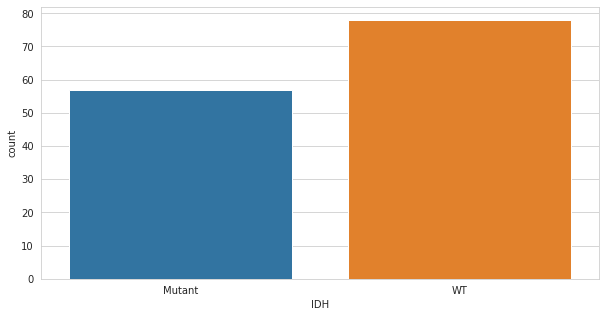

In [23]:
print('\n IDH values\n')
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
#sns.histplot(BraTS21MetaTrainDf, x = 'MGMT_value')
sns.countplot(x='IDH',data=BraTS20SubjectsIDHWithMetaDF)

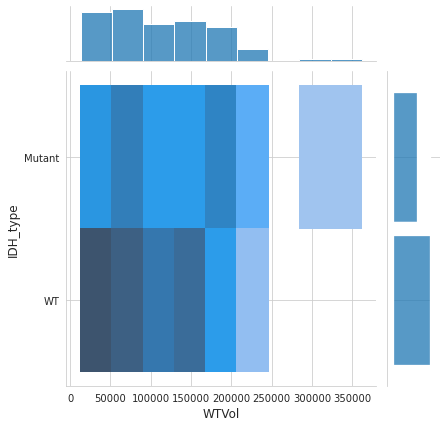

In [24]:
sjp = sns.jointplot(data=BraTS20SubjectsIDHWithMetaDF, x="WTVol", y="IDH", kind="hist")
sjp.set_axis_labels('WTVol', 'IDH_type', fontsize=12)
#plt.savefig('assets/JoinMGMTWTVolFig.png', dpi=300)

## Box plots
### For tumor volume

<AxesSubplot:xlabel='IDH', ylabel='NECVol'>

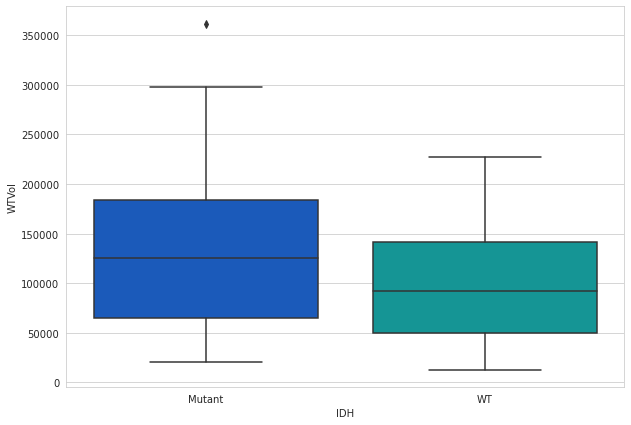

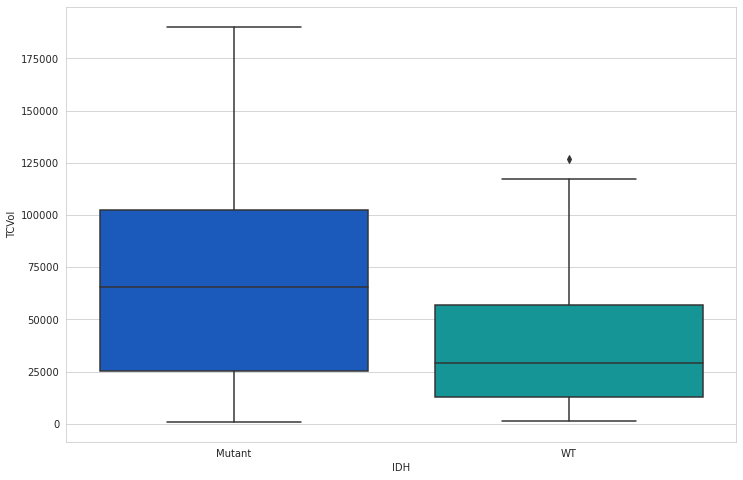

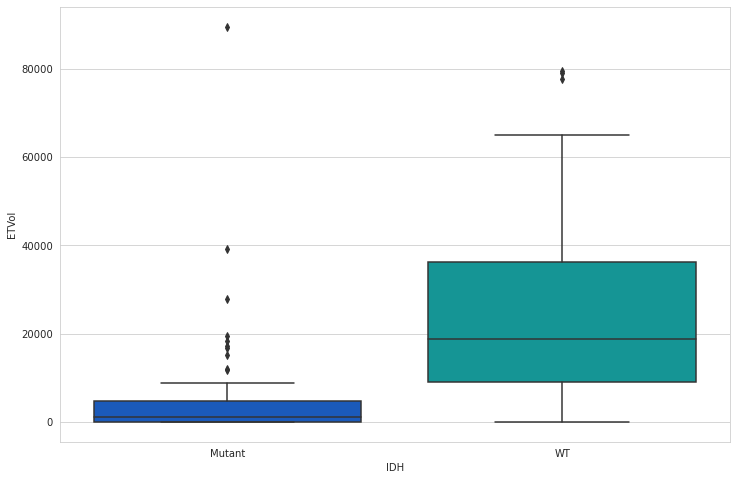

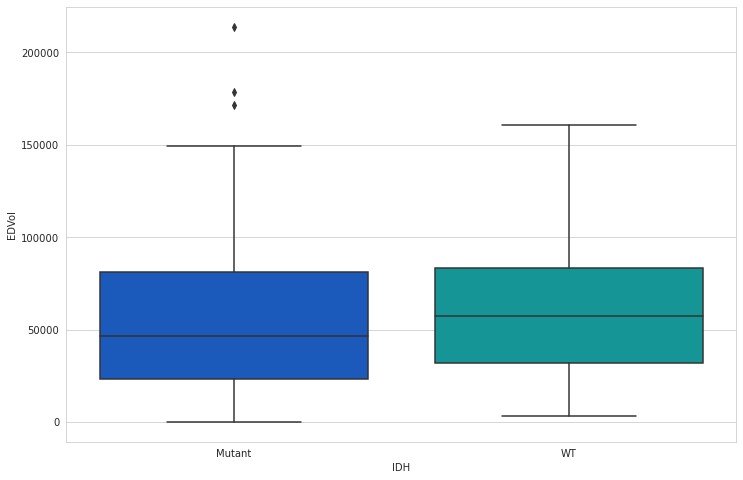

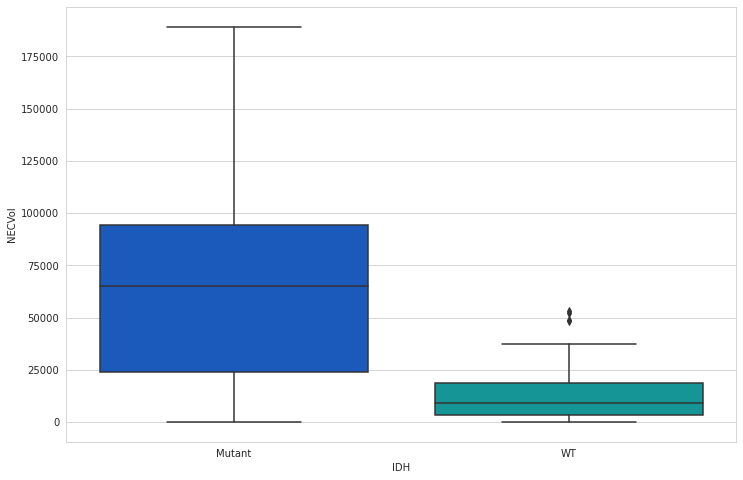

In [25]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='IDH',y='WTVol',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(12, 8))
sns.boxplot(x='IDH',y='TCVol',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(12, 8))
sns.boxplot(x='IDH',y='ETVol',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(12, 8))
sns.boxplot(x='IDH',y='EDVol',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(12, 8))
sns.boxplot(x='IDH',y='NECVol',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')

### For tumor coordinates


ET Coordinates


NEC Coordinates


Edema Coordinates


 Tumor core Coordinates


Whote tumor Coordinates



<AxesSubplot:xlabel='IDH', ylabel='WT_CoordZ'>

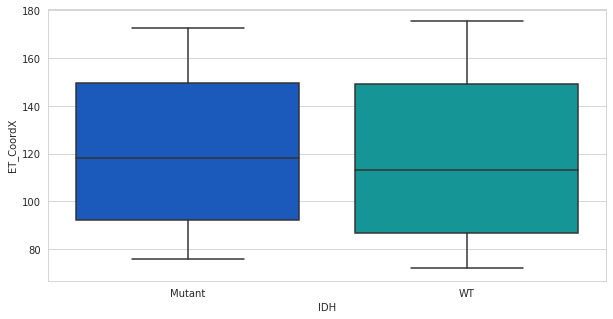

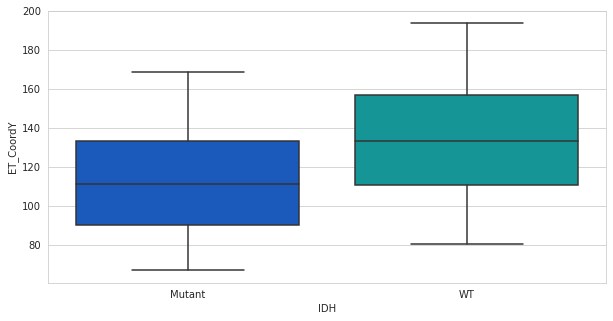

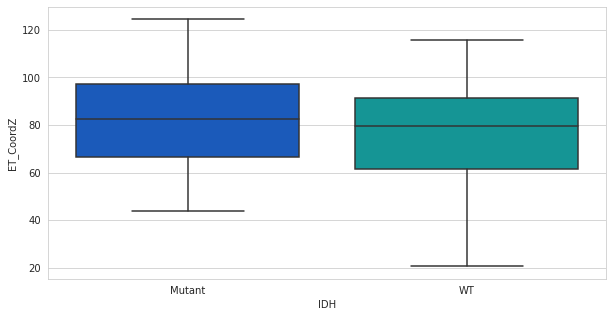

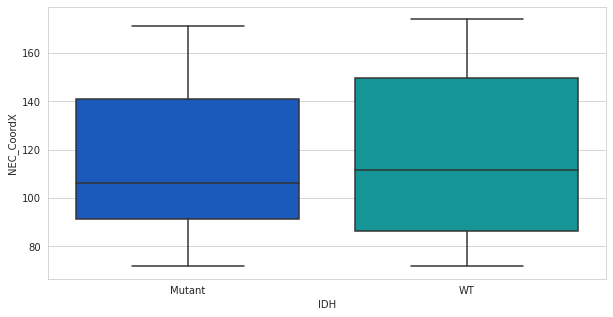

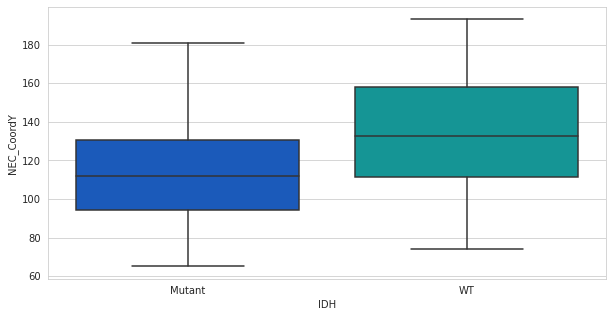

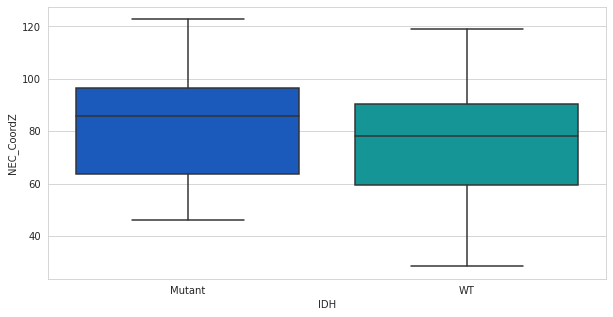

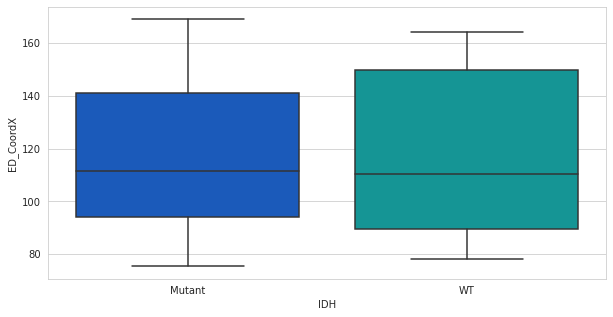

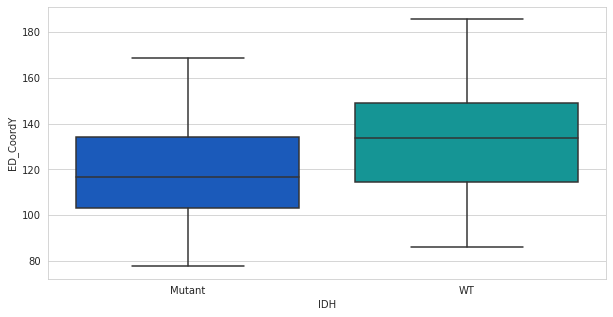

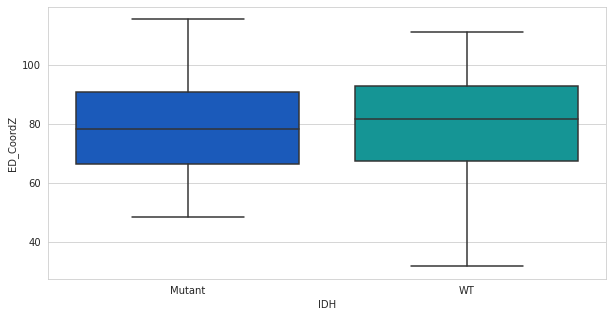

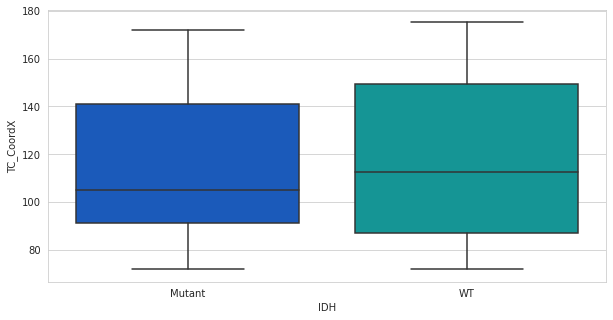

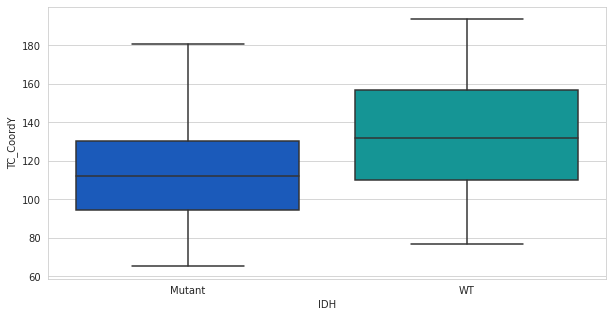

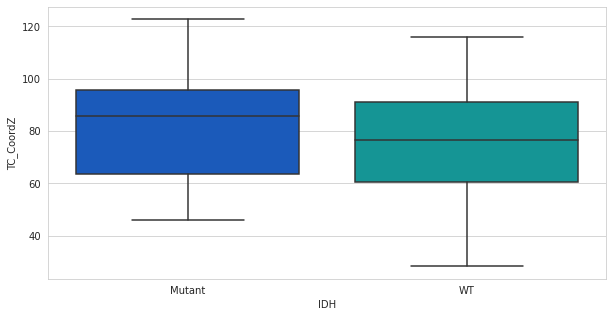

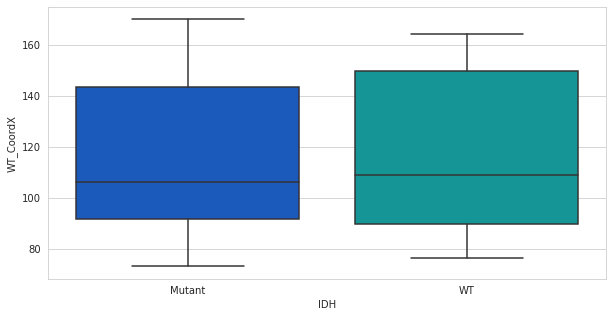

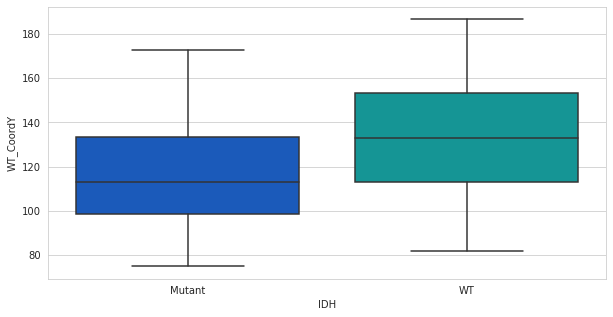

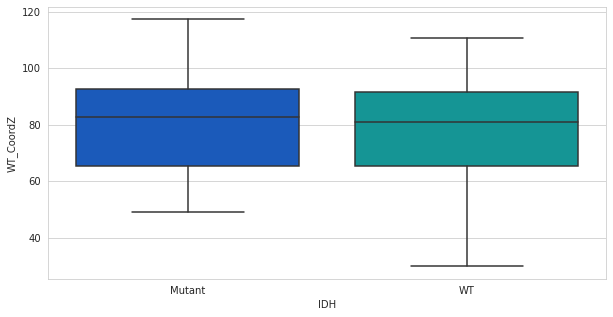

In [26]:
print('\nET Coordinates\n')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ET_CoordX',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ET_CoordY',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ET_CoordZ',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')

print('\nNEC Coordinates\n')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='NEC_CoordX',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='NEC_CoordY',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='NEC_CoordZ',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')

print('\nEdema Coordinates\n')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ED_CoordX',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ED_CoordY',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='ED_CoordZ',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')


print('\n Tumor core Coordinates\n')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='TC_CoordX',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='TC_CoordY',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='TC_CoordZ',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')

print('\nWhote tumor Coordinates\n')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='WT_CoordX',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='WT_CoordY',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')
plt.figure(figsize=(10, 5))
sns.boxplot(x='IDH',y='WT_CoordZ',data=BraTS20SubjectsIDHWithMetaDF, palette='winter')

### Reading dataframe having image paths/mask parhs/segmentated mask(GT) paths and IDH class label

## Cearing a list of dictionaries in order to feed into Monai's Dataset
Keys:
- ***image:*** T1, T1c, T2, and flair image
- ***label:*** Segmented mask GT
- ***brain_mask:*** Whole brain area (brain area=1 and Non brain area=0)
- ***IDH_value:*** IDH class corresponding to the subject/images

In [27]:
train_files = [{'image': (image_nameT1, image_nameT1ce, image_nameT2, image_nameFl), 'label': label_name, 'brain_mask':brain_mask, 'IDH_label': np.array(IDH_label_name)} 
               for image_nameT1,image_nameT1ce, image_nameT2, image_nameFl, label_name, brain_mask, IDH_label_name 
               in zip(BraTS20SubjectsIDHWithMetaDF['t1wPath'], BraTS20SubjectsIDHWithMetaDF['t1cwPath'], BraTS20SubjectsIDHWithMetaDF['t2wPath'], BraTS20SubjectsIDHWithMetaDF['flairPath'],\
                     BraTS20SubjectsIDHWithMetaDF['segPath'], BraTS20SubjectsIDHWithMetaDF['t1w_BrainmaskPath'], BraTS20SubjectsIDHWithMetaDF['IDH_value'])]

# train_files_image = [(image_nameT1, image_nameT1ce, image_nameT2, image_nameFl) 
#                      for image_nameT1,image_nameT1ce, image_nameT2, image_nameFl 
#                      in zip(dfTrainLbl['t1wPath'], dfTrainLbl['t1cwPath'], dfTrainLbl['T2wPath'], dfTrainLbl['FlairPath'])]
# train_files_label = dfTrainLbl['segPath'].tolist()
# train_files_brain_mask = dfTrainLbl['brain_maskPath'].tolist()
# train_files_IDH_label = dfTrainLbl['IDH_value'].values.ravel().tolist()


## Creating 5 splits for cross validaion (5 cross validaion)

In [28]:
n_splits = 3
#train_index = np.linspace(0, train_features.shape[0]-1, num = train_features.shape[0], dtype = np.uint16, endpoint=True)
#partition_data = monai.data.utils.partition_dataset_classes(train_index, train_labels.values.ravel().tolist(), shuffle=True, num_partitions=n_splits) 
#partition_data = monai.data.utils.partition_dataset_classes(train_files, dfTrainLbl['IDH_value'].values.ravel().tolist(), shuffle=True, num_partitions=n_splits)
partition_data = monai.data.partition_dataset_classes(train_files, BraTS20SubjectsIDHWithMetaDF['IDH_value'].values.ravel().tolist(), shuffle=True, num_partitions=n_splits)
print(len(partition_data), len(partition_data[0]), len(partition_data[1]), len(partition_data[2]))


# val_folds = {}
# train_folds = {}
# flds = np.linspace(0, n_splits, num=n_splits, dtype = np.int8)
# for cfold in range(n_splits):
#     not_cfold = np.delete(flds, cfold)
#     val_folds[cfold] = partition_data[cfold]
# #     train_folds[cfold] = 
# # sub_flds = flds[..., ~0]   
# # sub_flds

val_folds = {}
train_folds = {}
flds = np.linspace(0, n_splits, num=n_splits, dtype = np.uint8)
for cfold in range(n_splits):
    #val_folds[f"fold{cfold}"] = train_features.values[partition_data[cfold],:]
    #train_folds[f"fold{cfold}"] = np.delete(train_features.values, partition_data[cfold], axis=0)
    #not_cfold = np.delete(flds, cfold)
    
    val_folds[f"fold{cfold}"] = partition_data[cfold]
    val_folds[f"fold{cfold}_IDH_label"] = [adct['IDH_label'].item() for adct in partition_data[cfold]]
    train_folds_masks = [1]*n_splits
    train_folds_masks[cfold] = 0
    partition_data_non_cfold = list()
    for aDctLstitem in compress(partition_data, train_folds_masks):
        partition_data_non_cfold.extend(aDctLstitem)
        
        
    train_folds[f"fold{cfold}"] = partition_data_non_cfold
    train_folds[f"fold{cfold}_IDH_label"] = [adct['IDH_label'].item() for adct in partition_data_non_cfold]

for i in range(n_splits):
    print('val: ', len(val_folds[f'fold{i}']), 'train: ', len(train_folds[f'fold{i}']), '\n')

3 45 45 45
val:  45 train:  90 

val:  45 train:  90 

val:  45 train:  90 



In [29]:

for i_cv in range(n_splits):
    print('Training classes\n')
    print(np.unique([train_folds[f'fold{i_cv}'][i]['IDH_label'].item() for i in range(len(train_folds[f'fold{i_cv}']))], return_counts = True))
    print('\nValidation classes\n')
    print(np.unique([val_folds[f'fold{i_cv}'][i]['IDH_label'].item() for i in range(len(val_folds[f'fold{i_cv}']))], return_counts = True))
    print('#'*4, '\n\n')

Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 


Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 


Training classes

(array([0, 1]), array([38, 52]))

Validation classes

(array([0, 1]), array([19, 26]))
#### 




In [30]:
val_folds['fold0']

[{'image': ('/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173/BraTS20_Training_173_t1.nii.gz',
   '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173/BraTS20_Training_173_t1ce.nii.gz',
   '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173/BraTS20_Training_173_t2.nii.gz',
   '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173/BraTS20_Training_173_flair.nii.gz'),
  'label': '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173/BraTS20_Training_173_seg.nii.gz',
  'brain_mask': '/home/mmiv-ml/data/ROIBrain_MICCAI_BraTS2020/BraTS20_Training_173/BraTS20_Training_173_BrainROI.nii.gz',
  'IDH_label': array(1)},
 {'image': ('/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_277/BraTS20_Training_277_t1.nii.gz',
   '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_277/BraTS20_Training_277_t1ce.nii.gz',
   '/home/mmiv-ml/data/MICCAI_BraTS2020_TrainingData/BraTS20_Trainin

In [31]:
fold0Set = {val_folds['fold0'][j]['label'] for j in range(len(val_folds['fold0']))}
fold1Set = {val_folds['fold1'][j]['label'] for j in range(len(val_folds['fold1']))}
fold2Set = {val_folds['fold2'][j]['label'] for j in range(len(val_folds['fold2']))}
print(len(fold0Set)), print(len(fold1Set)), print(len(fold2Set))

45
45
45


(None, None, None)

In [32]:
print(len(fold0Set-fold1Set)), print(len(fold1Set-fold0Set)), print(len(fold0Set-fold2Set)), print(len(fold2Set-fold0Set))

45
45
45
45


(None, None, None, None)

In [33]:
 print(len(fold1Set-fold2Set)), print(len(fold2Set-fold1Set))

45
45


(None, None)